# Advanced Lane Line Perception Pipeline

# Camera Calibration

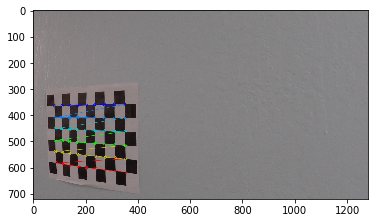

In [643]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import random
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
corner_imgs = []
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        corner_imgs.append( cv2.drawChessboardCorners(img, (9, 6), corners, ret))
        
randidx = random.randint(0, len(corner_imgs)-1)

plt.imshow(corner_imgs[randidx])

# Distortion Correction

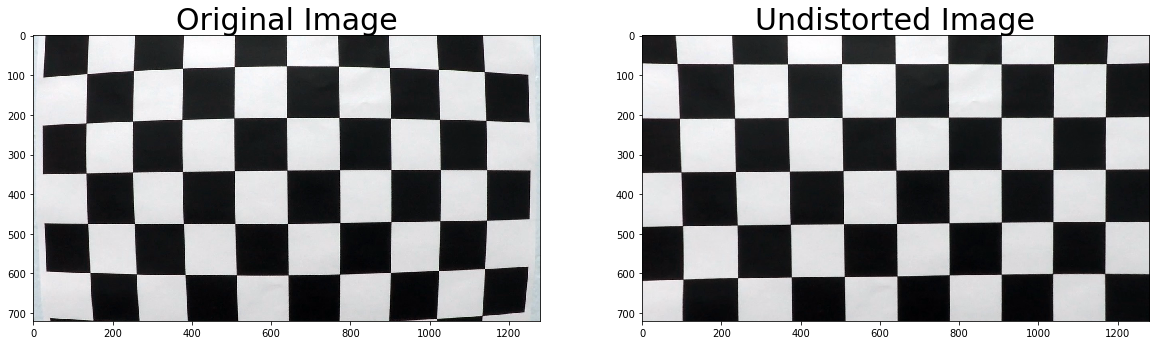

In [644]:
# Test undistortion on an image

img = cv2.imread(images[1])
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/camera_undist.jpg')

## Apply Perspective Transformation

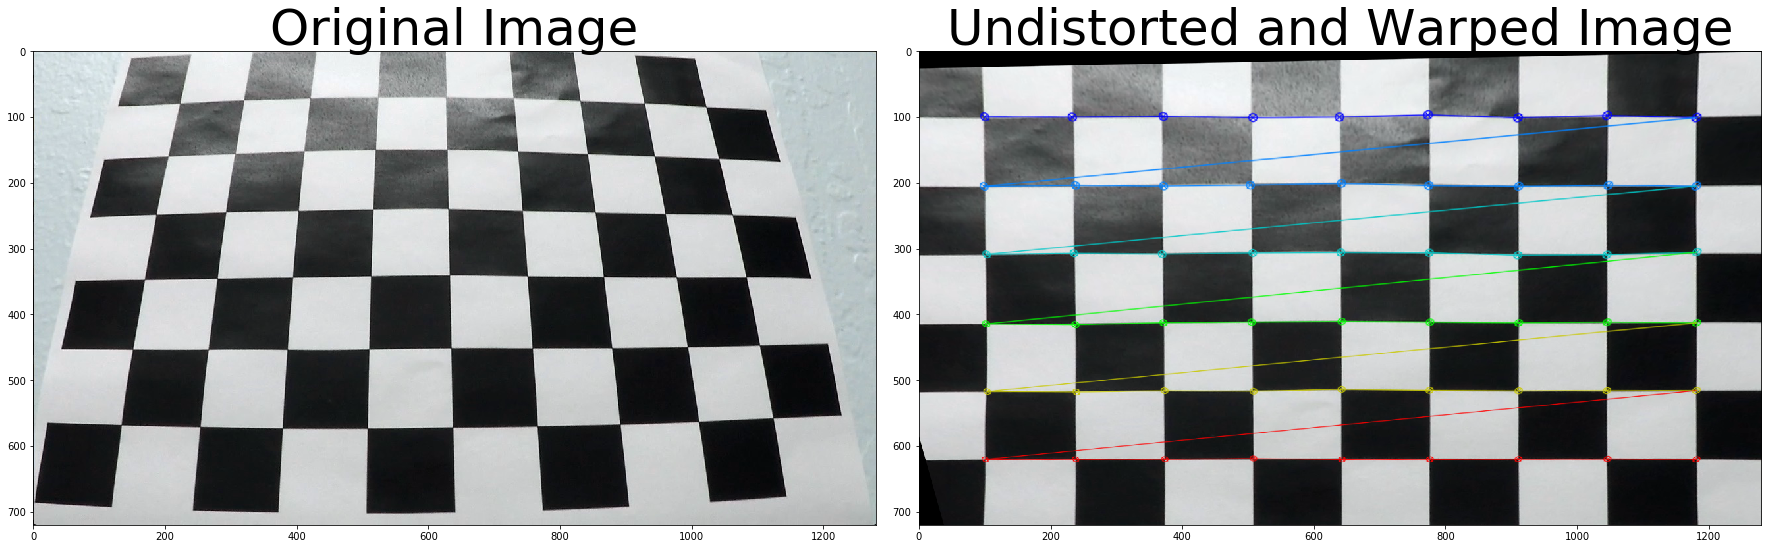

In [981]:
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread(images[2])
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)
    
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])
        
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warp = cv2.warpPerspective(undist, M, img_size,flags=cv2.INTER_LINEAR)
    return warp, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('test_images/camera_udist_warp.jpg')

# Image Masking

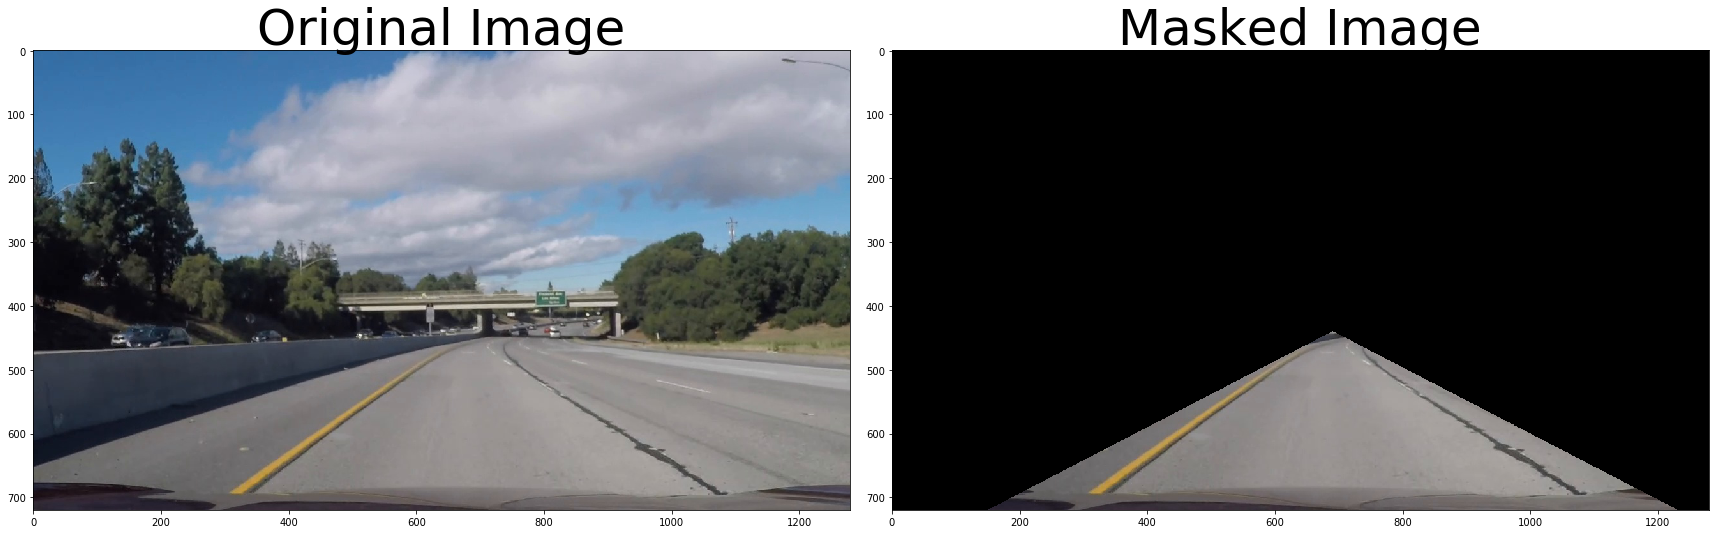

In [1012]:

def region_of_interest(img):
    imshape = img.shape
    vertices = np.array([[(150, imshape[0]),
                          (imshape[1] / 2+50 , imshape[0] / 2 +80),
                          (imshape[1] / 2+50, imshape[0] / 2 +80),
                          (imshape[1]-50, imshape[0])]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(region_of_interest(image))
ax2.set_title('Masked Image', fontsize=50)
plt.savefig('output_images/masked.jpg')

# Color and Gradient Threshold

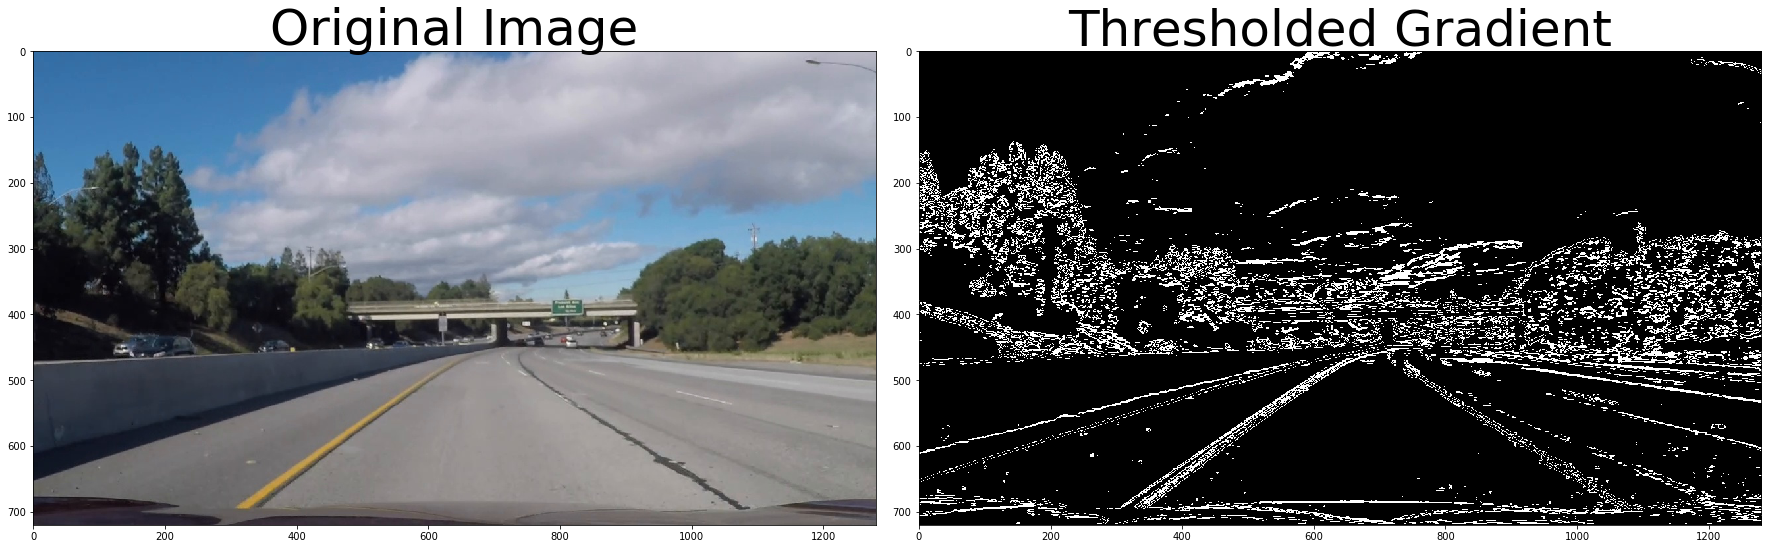

In [1011]:
#def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
image = mpimg.imread('test_images/10.jpg',)
# Run the function
grad_binary = abs_sobel_thresh(image, orient='y', thresh=(10,30))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('output_images/soebel_threshY.jpg')

## Thresholding by Magnitude of Gradient

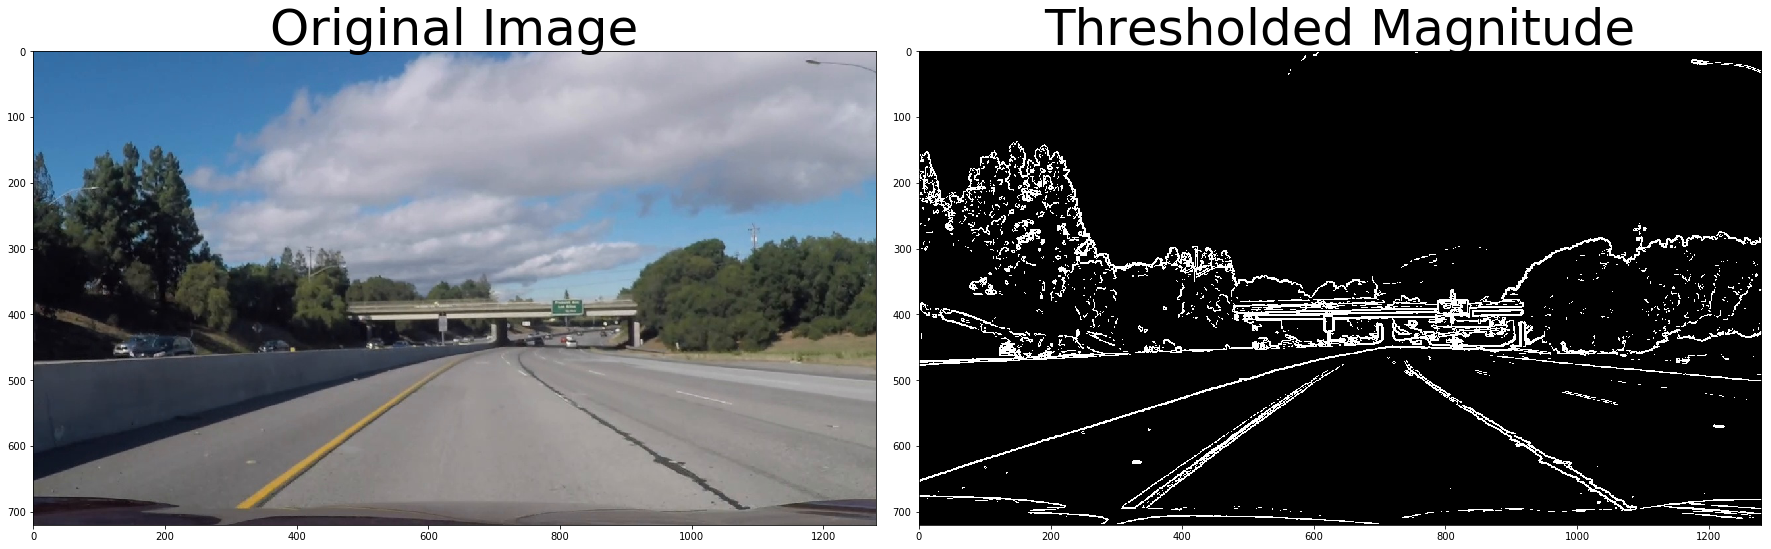

In [648]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 255)):   
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(img) # Remove this line
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image,mag_thresh=(30, 255))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/mag_thresh.jpg')

## Thresholding by Direction of Gradient

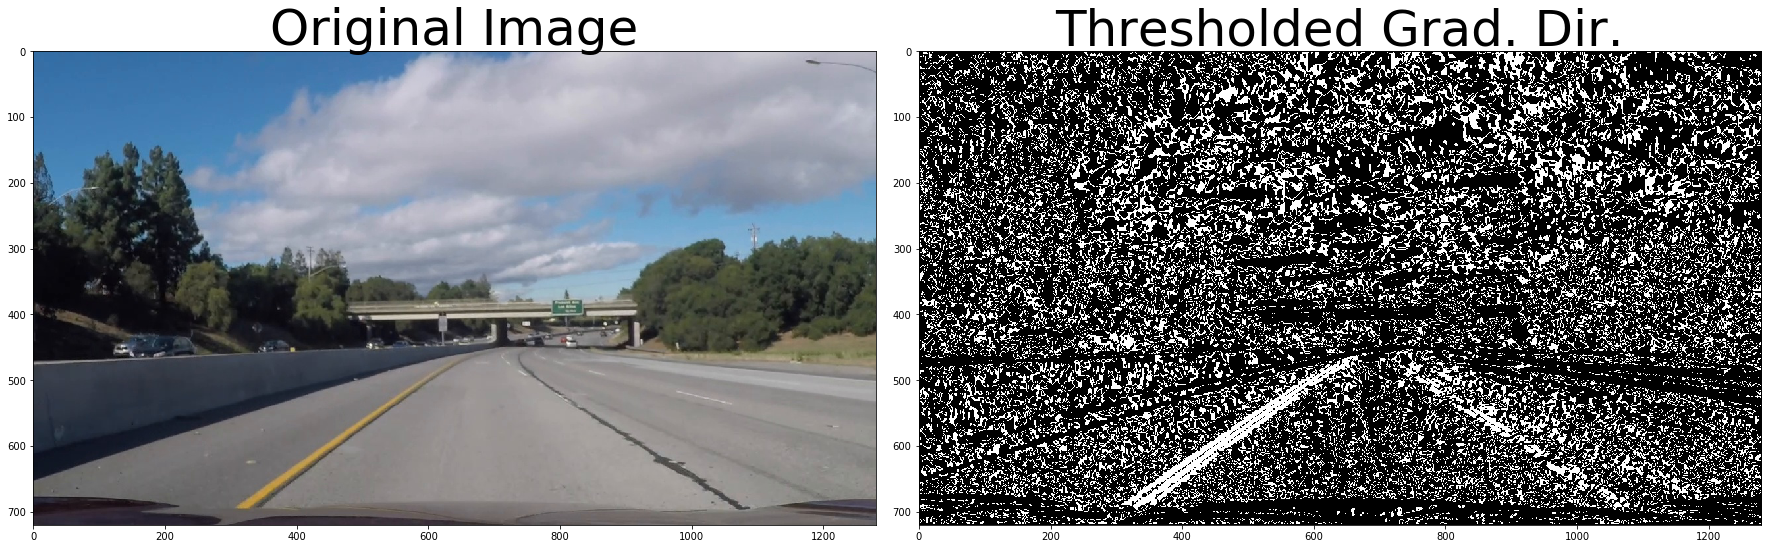

In [649]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(img) # Remove this line
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.8, 1.2))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/dir_thresh.jpg')

## Color Thresholding - Yellow and White

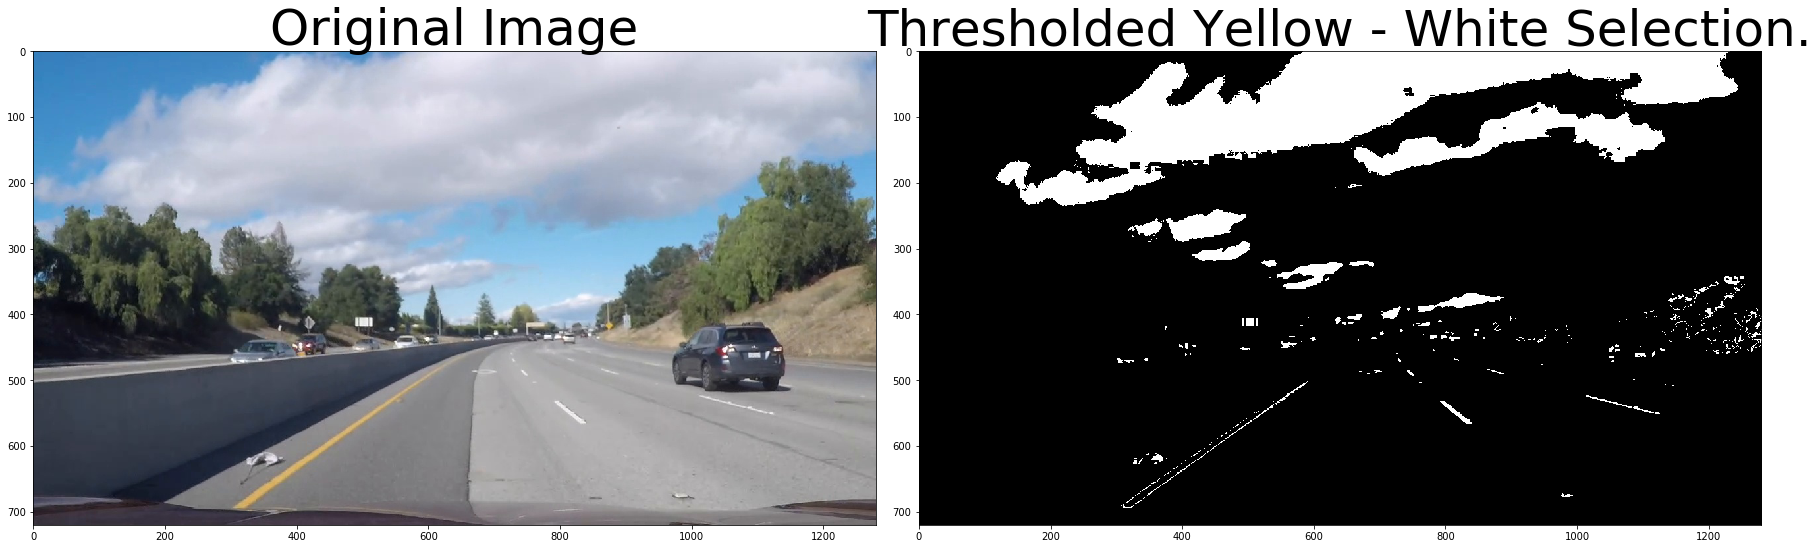

In [1007]:
def c_f(img, rgb_thresh=(195, 195, 125)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be BELOW all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def b_f(img, rgb_thresh=(155, 145, 50)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return  np.logical_and(color_select,c_f(img))

def color_thresh(img, rgb_thresh=(195, 195, 195)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return  np.logical_or(color_select,b_f(image))


color_select = color_thresh(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(color_select, cmap='gray')
ax2.set_title('Thresholded Yellow - White Selection.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/combined_thresh.jpg')

## Egde Selection - Color and Gradient Combination

<class 'numpy.ndarray'>
[False False False ..., False False False]


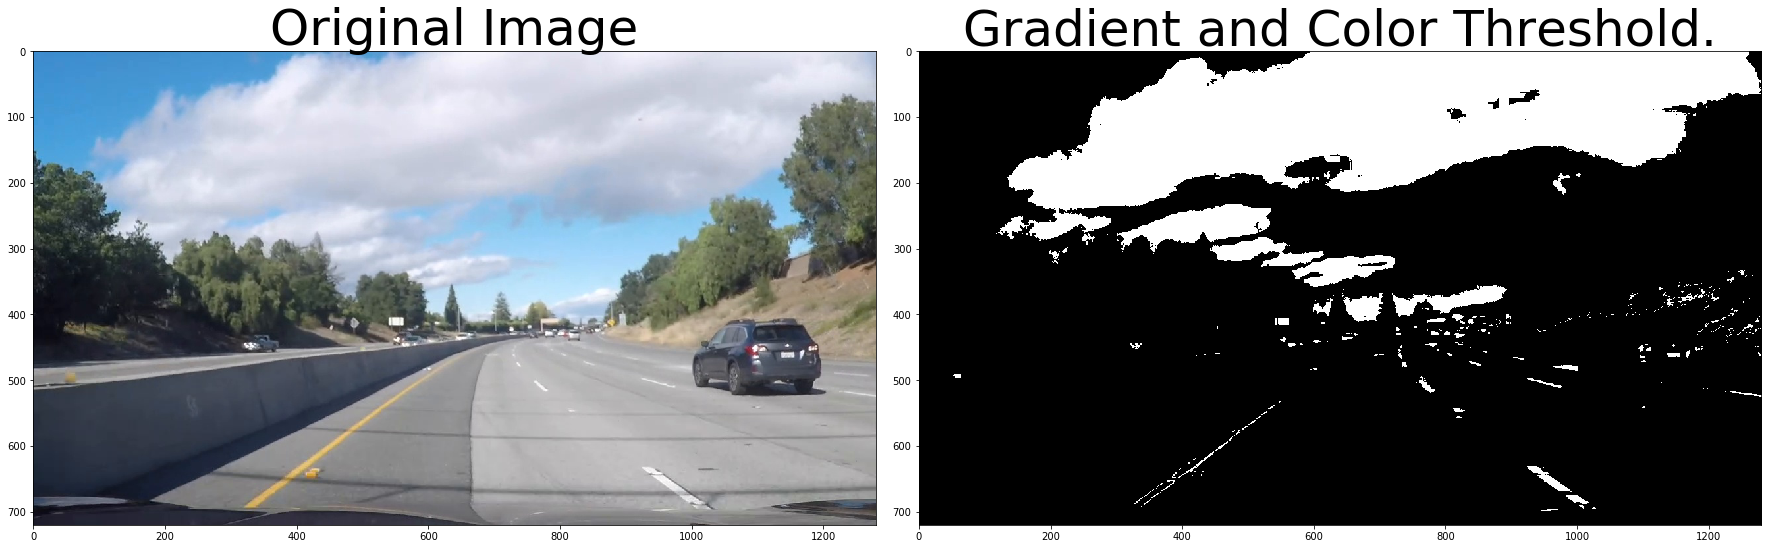

In [1009]:
image = mpimg.imread('test_images/160.jpg') 
def edges(im):
    #im = region_of_interest(im)
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    gradx = abs_sobel_thresh(im, orient='x', sobel_kernel=ksize, thresh=(100, 200))
    grady = abs_sobel_thresh(im, orient='y', sobel_kernel=ksize, thresh=(100, 255))
    mag_binary = mag_thresh(im, sobel_kernel=ksize, mag_thresh=(120,100))
    dir_binary = dir_threshold(im, sobel_kernel=ksize, thresh=(.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((grady == 1))&((mag_binary == 1) & (dir_binary == 1))] = 1
    a = np.logical_and(color_thresh(im),dir_binary)
    return (color_thresh(im).astype(np.uint8) | combined.astype(np.uint8)).astype(np.float32)


cd = color_thresh(image)
print(type(cd))
print(cd[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cd, cmap='gray')
ax2.set_title('Gradient and Color Threshold.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/combined_thresh.jpg')

## HLS Select - Saturation Selection

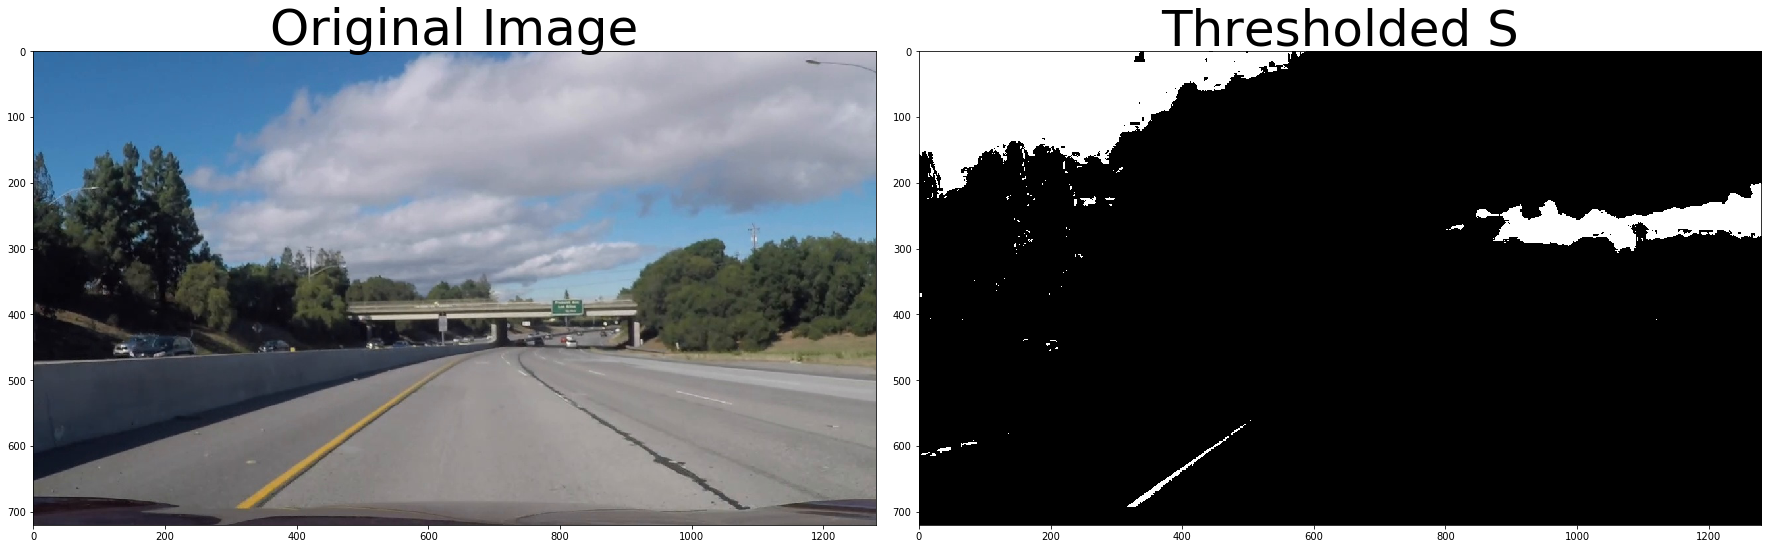

In [991]:
image = mpimg.imread('test_images/10.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(90, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    #img = region_of_interest(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    thresh_min = 110
    thresh_max = 225
    
    s_output = np.zeros_like(s_channel)
    s_output[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
       
    return s_output
   
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/hls_thresh.jpg')

## 

(720, 1280, 3)

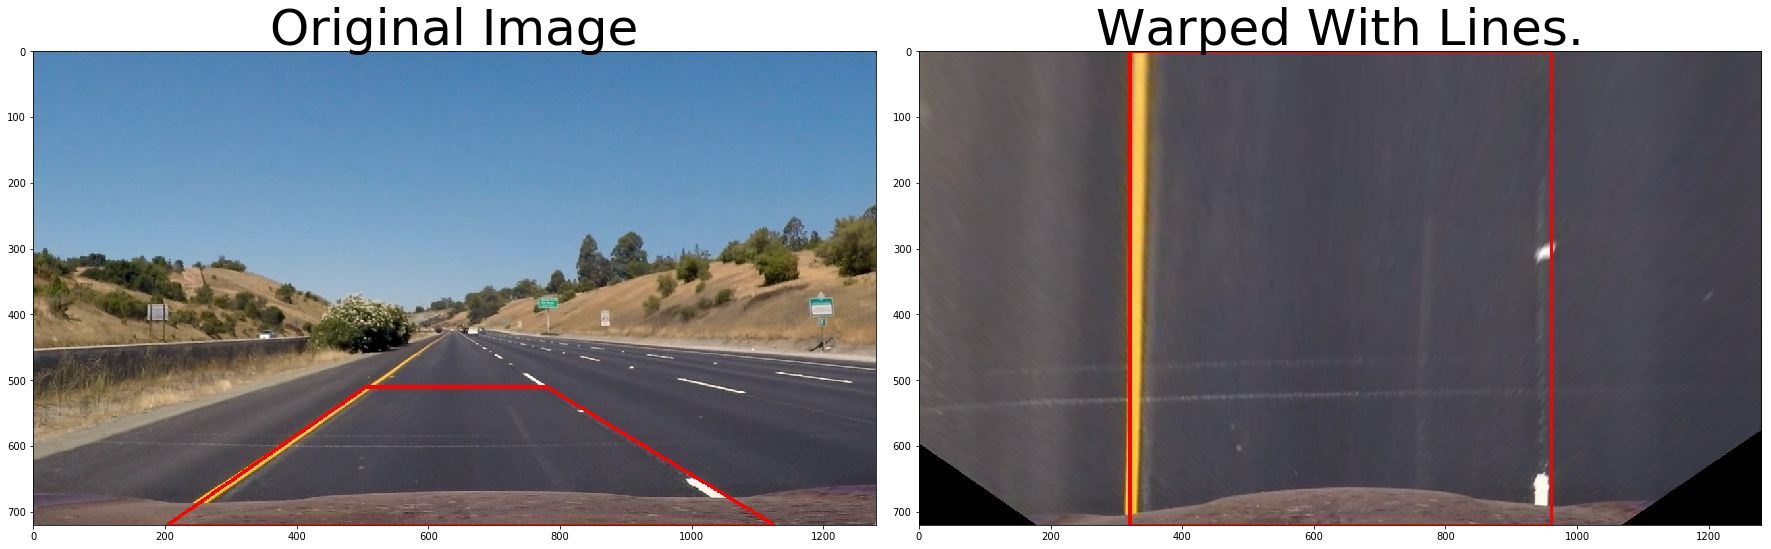

In [1013]:
def lines_perspective(img, mtx, dist):
    im = np.copy(img)
    warp = perspective(im, src, dst,mtx,dist)

    lineThickness = 4
    cv2.line(im, (src[0][0], src[0][1]), (src[1][0], src[1][1]), (255,0,0), lineThickness)
    cv2.line(im, (src[2][0], src[2][1]), (src[3][0], src[3][1]), (255,0,0), lineThickness)
    cv2.line(im, (src[1][0], src[1][1]), (src[2][0], src[2][1]), (255,0,0), lineThickness)
    cv2.line(im, (src[3][0], src[3][1]), (src[0][0], src[0][1]), (255,0,0), lineThickness)

    cv2.line(warp, (dst[0][0],dst[0][1]), (dst[1][0],dst[1][1]), (255,0,0), lineThickness)
    cv2.line(warp, (dst[2][0],dst[2][1]), (dst[3][0],dst[3][1]), (255,0,0), lineThickness)
    cv2.line(warp, (dst[1][0], dst[1][1]), (dst[2][0], dst[2][1]), (255,0,0), lineThickness)
    cv2.line(warp, (dst[3][0], dst[3][1]), (dst[0][0], dst[0][1]), (255,0,0), lineThickness)

    return warp, im

def perspective(img, src, dst,mtx,dist):
    img = np.copy(img)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    
    return cv2.warpPerspective(undist, M, img_size,flags=cv2.INTER_LINEAR)

image = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1],img.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 135, img_size[1] / 2 + 150],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 140), img_size[1] / 2 + 150]])


# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


perspective, origional = lines_perspective(image, mtx,dist)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(origional)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(perspective, cmap='gray')
ax2.set_title('Warped With Lines.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/warp_perspective.jpg')
image.shape

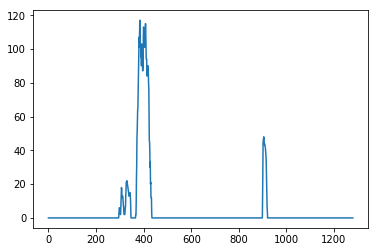

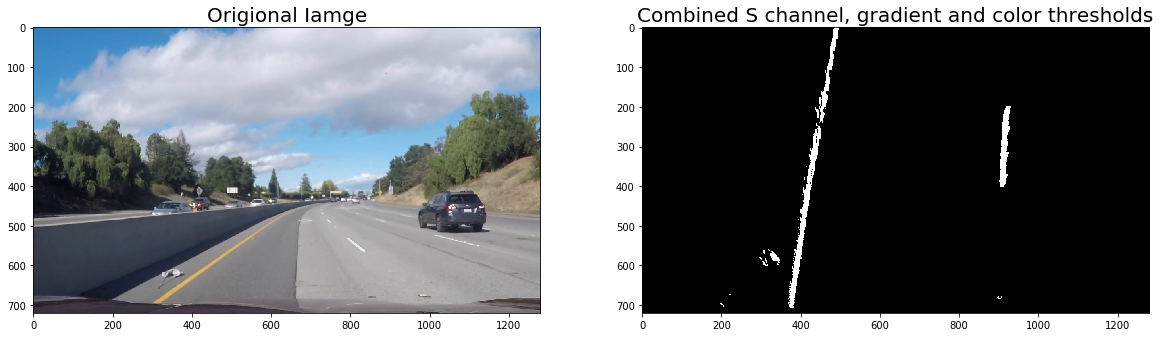

In [1017]:
master_image = mpimg.imread('test_images/180.jpg')
def perspective(img, src, dst,mtx,dist):
    img = np.copy(img)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    
    return cv2.warpPerspective(undist, M, img_size,flags=cv2.INTER_LINEAR)
image = master_image



def pipeline(img):
    # Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
    img = np.copy(img)
    sxbinary = edges(img)

    # Threshold color channel
   
    s_binary = hls_select(img)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary ,perspective(combined_binary, src, dst,mtx,dist)



color_binary, result = pipeline(image)
histogram = np.sum(result[result.shape[0]//2:,:], axis=0)
histogram[:250]= 0
histogram[500:900]=0
histogram[1050:]= 0
plt.plot(histogram)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Origional Iamge',fontsize=20)
ax1.imshow(image)

ax2.set_title('Combined S channel, gradient and color thresholds',fontsize=20)
ax2.imshow(result, cmap='gray')
plt.show()
plt.savefig('output_images/hist_warped.jpg')

(10340,)


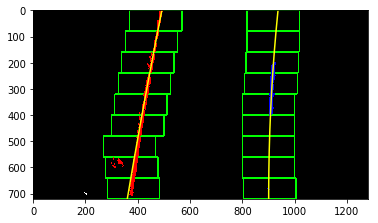

In [1001]:
binary_warped = np.copy(result)
#histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.array(cv2.merge((binary_warped*255,binary_warped*255,binary_warped*255)),np.uint8)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print(leftx.shape)
plt.savefig('output_images/sliding_window.jpg')

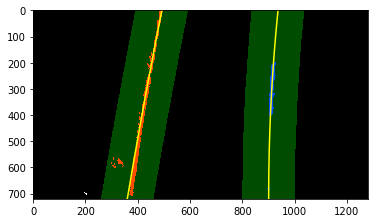

In [1002]:
out_img = np.array(cv2.merge((binary_warped*255,binary_warped*255,binary_warped*255)),np.uint8)
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
r = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(r)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/poly_fit.jpg')

25235.0072194 7045.18557123
7952.97886044 m 2314.00809323 m


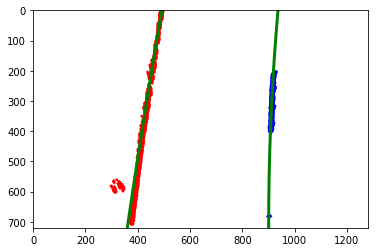

In [1003]:

mark_size = .5
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# # Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m
plt.savefig('output_images/cluster_fit.jpg')

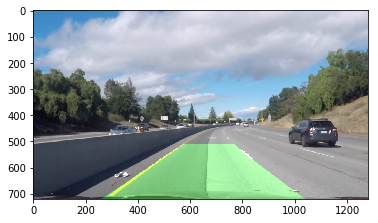

In [1004]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.array(cv2.merge((binary_warped*255,binary_warped*255,binary_warped*255)),np.uint8)
image = master_image
undist = cv2.undistort(image, mtx, dist, None, mtx)
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
# Combine the result with the original image
r = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

plt.imshow(r)
plt.savefig('output_images/final.jpg')